In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from Dataset_Construction import Balance_Ratio 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

### Identification of all kinds of  dimensional overlapping data
1. Corner : add 'cb', 'GB_mean' and 'GB_count' to dataset
2. Kind : only keep 'cb' which GB_mean = 0 or GB = 1 (data belong to good but overlap with bad are excluded)
3. Dictionary_Build : add G_count (amount of majority overlapping corner???)

In [2]:
def Corner(D, label = 'GB'):
    
    Data = D.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x: '_'.join(x.astype(str)), axis = 1)
    Data[f'{label}_mean'] = Data.groupby('cb')[label].transform('mean')
    Data[f'{label}_count'] = Data.groupby('cb')[label].transform('count')
    Corner_overlap = Data.copy() 
    
    return Corner_overlap


def Kind(Corner_overlap, label = 'GB'):

    Data = Corner_overlap
    
    Kinds_0 = Data[Data[f'{label}_mean'] == 0].sort_values(f'{label}_count') # represent all data in the same 'cb' are good  
    Kinds_1 = Data[Data[label] == 1].sort_values(f'{label}_count') # represent bad data
    Kinds = pd.concat([Kinds_1, Kinds_0]) # reprecent all types of 'cb'
    Kinds_after_duplicate = Kinds.drop_duplicates(subset = ['cb']).reset_index(drop = True) 
    # each 'cb' only keep one data(the first)
    
    return Kinds_after_duplicate


def Dictionary_Build(Data):
    
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)),axis=1)
    Data['GB_mean'] = Data.groupby('cb')['GB'].transform('mean')
    Data['GB_count'] = Data.groupby('cb')['GB'].transform('count')
    Corner_overlap = Data.copy()
    Kinds = Kind(Corner_overlap).copy()

    ## reorder cols
    cols = Kinds.columns.tolist()
    cols = cols[0:1] + cols[-4:] 
    Dictionary = Kinds[cols] #select id, GB, cb, GB_mean, GB_count
    Dictionary['G_count'] = 0 # add new column 
    Dictionary=Dictionary.reset_index(drop=True)
    for i in range(len(Dictionary)):
        Dictionary['G_count'][i] = Dictionary.GB_count[i] - Dictionary.GB[i] # represent??
    
    return Dictionary

### Relabel dimensional overlapping data
1. remove data located in non-overlap corner
2. relabel all data in specific corner by bad ratio
3. ideal PR curve due to corner overlap

In [3]:
def Remove_SD(Data, count = 1, label = 'GB'):
    
    Corner_Overlap = Data
    RSD = pd.concat([Data[Data[label] == 1], Data[(Data[label] == 0) & (Data[f'{label}_count'] > count)]]) 
    # remove good data that only show once
    return RSD


def Corner_Blend(Data, ratio = 0.002, label = 'GB'):
    
    D_1 = Data[(Data[f'{label}_mean'] <= 1) & (Data[f'{label}_mean'] >= ratio)].sort_values(f'{label}_count') # not relabel case
    D_1[[label]] = 1  #if G_mean > ratio ==> relabel all data as bad
    D_2 = Data[(Data[f'{label}_mean'] < ratio)].sort_values(f'{label}_count')
    D_2[[label]] = 0  # otherwise relabel all data as good
    Training_new = pd.concat([D_1,D_2]).iloc[:,:-3]
    
    return Training_new


def AUC(x,y):
    
    area=0
    for i in range(1,len(x)):
        height=x[i]-x[i-1]
        area=area+height*(y[i-1]+y[i])/2
        
    return area


def Idea_PR(D):
    
    Data = Corner(D)

    Kinds_0=Data[Data.GB_mean==0].sort_values('GB_count')
    Kinds_1=Data[Data.GB==1].sort_values('GB_count') # 
    Kinds=pd.concat([Kinds_1,Kinds_0])
    Test_Kinds=Kinds.drop_duplicates(subset=['cb']).reset_index(drop=True)
    print('num of Bad (test)',len(Kinds_1))
    print('kind of Bad (test)',len(Test_Kinds))
    
    Aging_amount=Test_Kinds[Test_Kinds.GB==1].GB_count.sum()
    Precision=np.cumsum(Test_Kinds[Test_Kinds.GB==1].GB)/np.cumsum(Test_Kinds[Test_Kinds.GB==1].GB_count)
    Recall=np.cumsum(Test_Kinds[Test_Kinds.GB==1].GB)/Test_Kinds[Test_Kinds.GB==1].GB.sum()
    area=AUC(Recall.values,Precision.values)
    ar=Aging_amount/len(Data)
    fig = plt.figure()
    ax = plt.axes()
    plt.title('AUC : %.3f \n\n Optimum_Aging_rate %.3f'%(area,ar))
    ax.plot(Recall,Precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

## Data Processing
1. Read data from 1.1
2. Remove single & relabel overlapping corner
3. Kinds & dictionary construction

### Event data

In [4]:
TrainingSet_0 = pd.read_csv('original_data/TrainingSet_0.csv').iloc[:, 1:]
TestingSet_0 = pd.read_csv('original_data/TestingSet_0.csv').iloc[:, 1:]
DataSet = pd.read_csv('original_data/DataSet.csv').iloc[:, 1:]

print('Training Set:', TrainingSet_0.shape, '\nTesting Set:', TestingSet_0.shape, '\nDataSet:', DataSet.shape)

train_bad = sum(TrainingSet_0['GB'])
test_bad = sum(TestingSet_0['GB'])
print('\nNumber of bad data:', '\nTraining Data:', train_bad, ',  Testing Data:', test_bad)

Training Set: (80395, 84) 
Testing Set: (55903, 84) 
DataSet: (136298, 84)

Number of bad data: 
Training Data: 49 ,  Testing Data: 18


In [5]:
start = time.time()

Corner_overlap = Corner(TrainingSet_0)

RSD = Remove_SD(Corner_overlap, 1)
Training_new = Corner_Blend(RSD, 1/500)
Training_new.to_csv('TrainingSet_new.csv')
print('After Remove Single & Overlap Relabel :', Training_new.shape, ', Balance Ratio:', Balance_Ratio(Training_new))

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

NameError: name 'TrainingSet_0' is not defined

In [9]:
start = time.time()

Kinds = Kind(Corner_overlap).copy()
Kinds.to_csv('Kinds.csv')
print('Number of kinds:', len(Kinds))

Dictionary = Dictionary_Build(DataSet)
Dictionary.to_csv('Dictionary.csv')

end = time.time()
print("\nRun Time：%f seconds" % (end - start))

Number of kinds: 6093


C:\Users\Darui Yen\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Darui Yen\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Run Time：269.769338 seconds


num of Bad (test) 9
kind of Bad (test) 1345


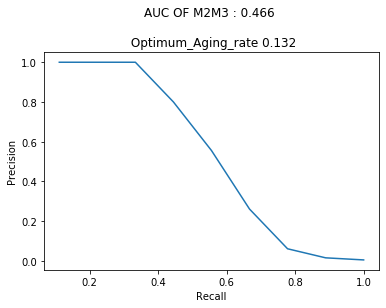

In [7]:
Idea_PR(TestingSet_0)

### Runhist data

In [5]:
train_runhist = pd.read_csv('train_runhist.csv').iloc[:, 1:]

overlap = Corner(train_runhist)
new_runhist = Corner_Blend(overlap, 1/10000)
new_runhist.to_csv('train_runhist_new.csv')
bad_count = len(new_runhist[new_runhist.GB == 1])

print('After Overlap Relabel :', new_runhist.shape, ', Balance Ratio:', Balance_Ratio(new_runhist), '# Bad:', bad_count)

After Overlap Relabel : (80395, 180) , Balance Ratio: 1100.30137 # Bad: 73


Number of kinds: 62976
num of Bad (test) 18
kind of Bad (test) 6957


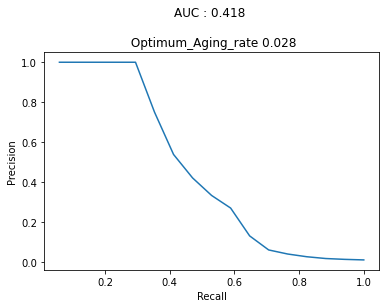

In [6]:
run_kind = Kind(overlap).copy()
#run_kind.to_csv('run_kind.csv')
print('Number of kinds:', len(run_kind))

Idea_PR(TestingSet_0)